# Machine Learning Project - Consumer Complaints

## The data

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

csv_files = 'data/complaints-2020-01-22_08_24/*.csv'
dataset = pd.concat([pd.read_csv(f, header=0, delim_whitespace=False) for f in glob.glob(csv_files)], ignore_index = True)
dataset.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,250000,02/17/17,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,My husband XXXX XXXX passed away on XXXX/XXXX/...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,750XX,Older American,Consent provided,Web,02/17/17,Closed with explanation,Yes,No,2350810
1,250001,03/31/17,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,Extortion excess escrow ; with threatened Fore...,Company believes it acted appropriately as aut...,Ditech Financial LLC,MI,48072,None,Consent provided,Web,03/31/17,Closed with explanation,Yes,Yes,2413884
2,250002,04/07/17,Debt collection,"Other (i.e. phone, health club, etc.)",Improper contact or sharing of info,Talked to a third party about my debt,I do not have a contract with Diversified Cons...,None,"Diversified Consultants, Inc.",MO,631XX,None,Consent provided,Web,04/07/17,Closed with explanation,Yes,No,2424349
3,250003,03/24/17,Consumer Loan,Title loan,Payment to acct not credited,None,"A 20 year loan at .0875 simple interest, in XX...",None,PNC Bank N.A.,FL,327XX,None,Consent provided,Web,03/24/17,Closed with explanation,Yes,No,2402336
4,250004,08/05/15,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,"I continue to get calls from this company, I b...",None,High Point Asset Inc,DE,199XX,Older American,Consent provided,Web,09/21/15,Closed with explanation,No,No,1503579


Initial data cleaning.

In [2]:
import re

# drop columns that aren't going to be used
cleaned_dataset = dataset.drop(['Unnamed: 0', 'Date received', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Company response to consumer', 'Timely response?', 'Date sent to company', 'Consumer disputed?', 'Complaint ID'], axis=1)
# remove any empty complaints if any exist
cleaned_dataset = cleaned_dataset[pd.notnull(dataset['Consumer complaint narrative'])]
# remove useless text parts
cleaned_dataset['Consumer complaint narrative'] = cleaned_dataset['Consumer complaint narrative'].replace(to_replace='xx/xx/\d{4}|XX/XX/\d{4}|\d\d/\d\d/\d{4}|xx/xx/\d{2}|XX/XX/\d{2}|\d\d/\d\d/\d{2}|xx+|XX+|{|}|\$\d+(\.\d+)?', value='', regex=True)
# replace consecutive spaces by only one space
cleaned_dataset['Consumer complaint narrative'] = cleaned_dataset['Consumer complaint narrative'].replace(to_replace='\s\s+', value=' ', regex=True)

In [3]:
cols = ['Product', 'Sub-product', 'Issue', 'Sub-issue']
ids = []
label_to_id = []
id_to_label = []

count = 0
for c in cols:
    one_hot_encoding = pd.get_dummies(cleaned_dataset[c], prefix = c)
    cleaned_dataset = pd.concat([cleaned_dataset, one_hot_encoding], axis = 1)
    
    cleaned_dataset[c + ' id'] = cleaned_dataset[c].factorize()[0]
    ids.append(cleaned_dataset[[c, c + ' id']].drop_duplicates().sort_values(c + ' id'))
    label_to_id.append(dict(ids[count].values))
    id_to_label.append(dict(ids[count][[c + ' id', c]].values))
    count += 1

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gwerrebr/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/gwerrebr/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/gwerrebr/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Data cleaning by removing symbols, short words, stopwords and by stemming words to their dictionary form by using a lemmatizer.

In [5]:
%%time

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def clean_col(col):
    cleaned_col = []
    for r in range(0,len(col)):
        row = str(col[r])
        row = re.sub('[^a-zA-Z]',' ', row)
        row = re.sub(r'\b\w{1}\b', '', row)

        word_tokens = word_tokenize(row)

        row = [w for w in word_tokens if w not in stop_words]
        row = ' '.join(row)
        row = [lemma.lemmatize(w) for w in word_tokenize(str(row).lower())]
        row = ' '.join(row)
        cleaned_col.append(row)
    return cleaned_col

cleaned_dataset['Consumer complaint narrative'] = clean_col(cleaned_dataset['Consumer complaint narrative'])

CPU times: user 23min 40s, sys: 3.26 s, total: 23min 43s
Wall time: 23min 43s


In [6]:
show_n_rows = 50

pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = show_n_rows

cleaned_dataset['Consumer complaint narrative'].head(show_n_rows)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


0     my husband passed away a imagine devastated we married almost year he father child business partner partner life my first several month passed away everyone kept asking thousand question finance house vehicle life insurance etc clue answer always handled finance eventually figured transitioned everything name within month except mortgage well fargo for reason difficult make call well fargo know we good position financially continued make payment time still want make call in hindsight think knew call wf would initiate closure life ready close knew soon name removed mortgage note mine added would real gathered paperwork wrote question made call needed notify well fargo passed away ask needed update account transition mortgage loan name note when purchased home mortgagor borrower mortgage note signed deed trust required document non borrowing spouse state texas on made first call well fargo spoke customer service notified husband passed away also told wanted well fargo loan mortgage

Train a Doc2Vec model.

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

X = cleaned_dataset['Consumer complaint narrative']
Y = [[i] for i in range(len(X))]
tagged_data  = [TaggedDocument(X[i], Y[i]) for i in range(len(X))]

max_epochs = 10
vector_size = 200
alpha = 0.025

model = Doc2Vec(vector_size=vector_size, alpha=alpha, min_alpha=0.00025, min_count=2, sample=0.00001, dm=1, workers=16)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

fname = "doc2vec_model"
model.save(fname)
print("Model Saved (" + fname + ")")

Model Saved (doc2vec_model)


Vectorize the whole dataset with the trained model.

In [9]:
from gensim.models.doc2vec import Doc2Vec

fname = "doc2vec_model"
model = Doc2Vec.load(fname)

vectorized_complaints = []
for x in X[:]:
    vectorized_complaints.append(model.infer_vector(list(x)))

Perform PCA on the vectorized dataset for outlier detection.

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(vectorized_complaints)
pca_vectorized_complaints = pca.transform(vectorized_complaints)

Perform SVD on the vectorized dataset for outlier detection.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd_vectorized_complaints = svd.fit_transform(vectorized_complaints)

Function to detect outliers with 4 different algorithms.

In [15]:
import time

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def compute_and_plot_outliers(data, outliers_fraction=0.01):
    anomaly_algorithms = [
        ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
        ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
        ("Isolation Forest", IsolationForest(contamination=outliers_fraction)),
        ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))
    ]

    xx, yy = np.meshgrid(np.linspace(-1, 1, 150), np.linspace(-1, 1, 150))

    y_preds = []
    
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()

        algorithm.fit(data)

        plt.figure(figsize=(10, 10))
        plt.title("Outlier detection with " + name, size=18)

        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(data)
        else:
            y_pred = algorithm.fit(data).predict(data)
        
        y_preds.append(y_pred)

        if name != "Local Outlier Factor":
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        t1 = time.time()

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(data[:, 0], data[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15, horizontalalignment='right')
        
        plt.show()
    
    return y_preds

Detect outliers both by using PCA and SVD.

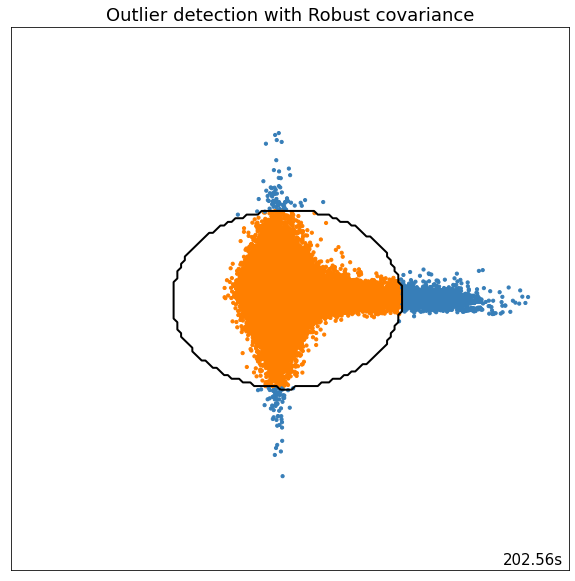

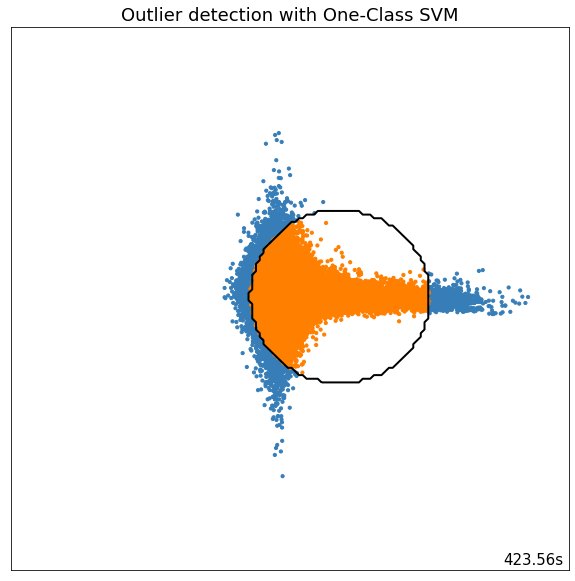

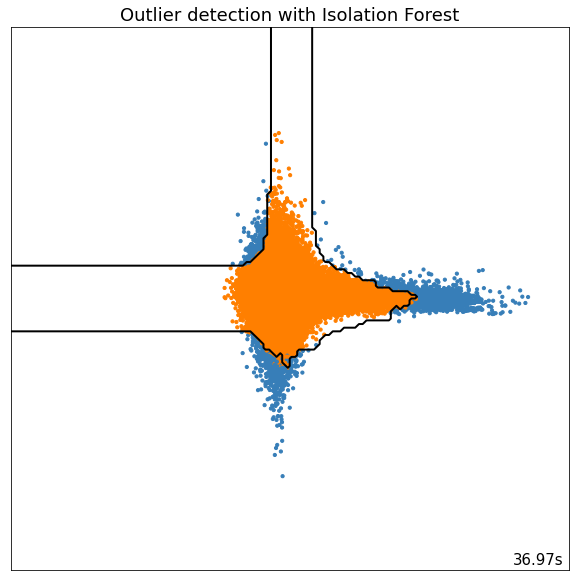

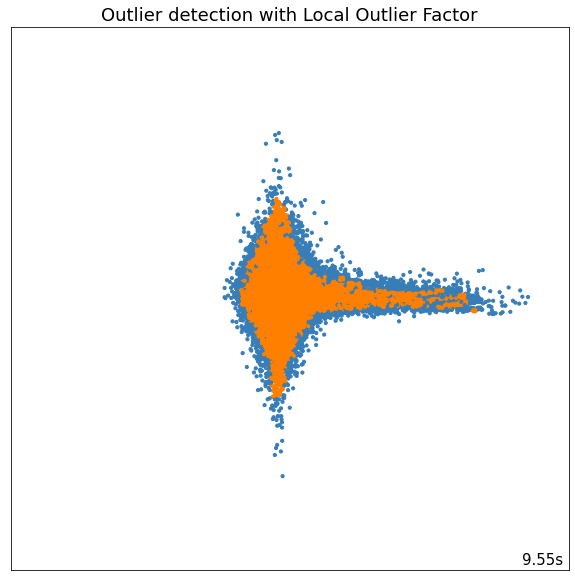

In [16]:
pca_y_preds = compute_and_plot_outliers(pca_vectorized_complaints)

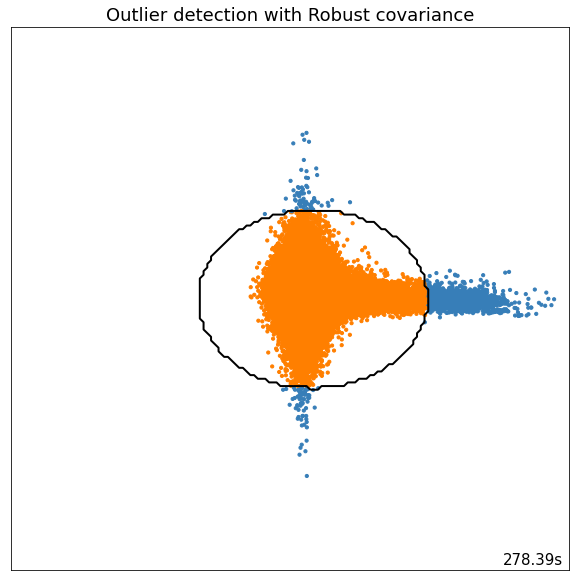

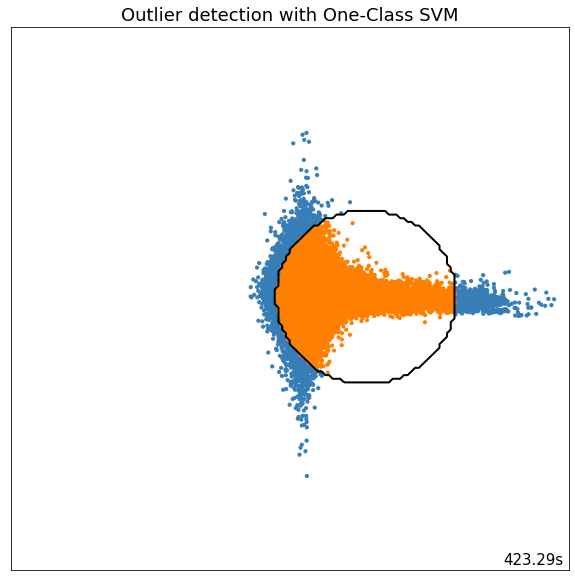

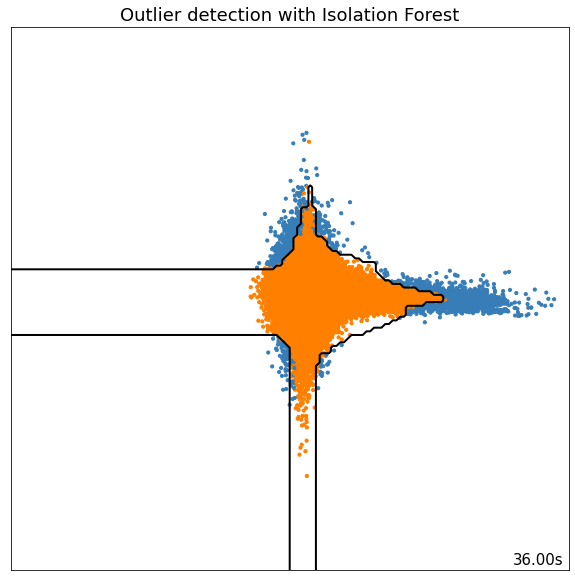

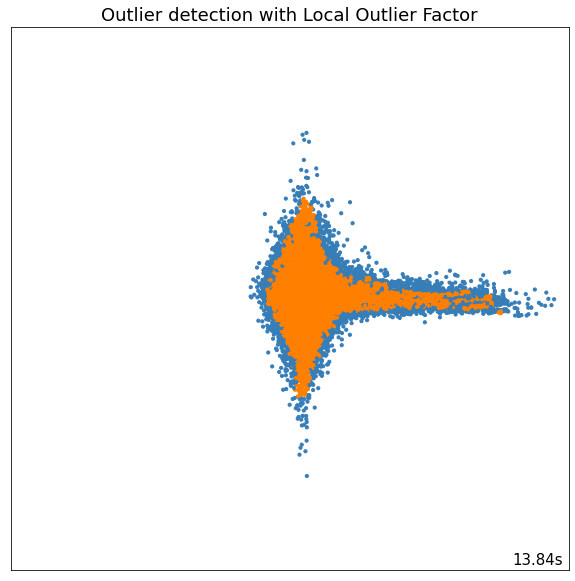

In [17]:
svd_y_preds = compute_and_plot_outliers(svd_vectorized_complaints)

Get all complaint ids that are labelled as outliers.

In [18]:
def get_outlier_ids(y_pred):
    outlier_ids = []

    for id in range(0, len(y_pred)):
        if y_pred[id] == -1:
            outlier_ids.append(id)
    
    return outlier_ids

Get all outliers per algorithm (PCA).

In [129]:
pca_outlier_ids = []
for o in range(0, len(pca_y_preds)):
    outliers = get_outlier_ids(pca_y_preds[o])
    pca_outlier_ids.append(outliers)
    
    print('#outliers:', len(outliers))

#outliers: 4857
#outliers: 4857
#outliers: 4856
#outliers: 4857


Get the intersection of the four outlier detection algorithms when using PCA.

In [128]:
pca_outliers_intersection = list(set(pca_outlier_ids[0]) & set(pca_outlier_ids[1]) & set(pca_outlier_ids[2]) & set(pca_outlier_ids[3]))
print('# of common outliers in all four outlier detection algorithms using PCA:', len(pca_outliers_intersection))

# of common outliers in all four outlier detection algorithms using PCA: 739


In [65]:
print(pca_outliers_intersection)

[260097, 456706, 26629, 389125, 360456, 432143, 294930, 260115, 198676, 67609, 329753, 22554, 358431, 290848, 135202, 122916, 372783, 110641, 208945, 184380, 329790, 180287, 141376, 47170, 219204, 184390, 452682, 391243, 180302, 180303, 133204, 151637, 108630, 247902, 417889, 32868, 51301, 401510, 67686, 239719, 354407, 436327, 168039, 96362, 329843, 209015, 411772, 12413, 116863, 96383, 348290, 311427, 409731, 16531, 94358, 313498, 297116, 63648, 215202, 147619, 53415, 34988, 313517, 51375, 127156, 4279, 96447, 151744, 420034, 106691, 413892, 184517, 436422, 180424, 248010, 372939, 145620, 149721, 184538, 241883, 26845, 276701, 51425, 147687, 155879, 127207, 88295, 170224, 454903, 164096, 57602, 24836, 266500, 125190, 434440, 454920, 430346, 399624, 379150, 10522, 231706, 321826, 483620, 366898, 164150, 121143, 344379, 461120, 92482, 461123, 28995, 49477, 166222, 436558, 248147, 452948, 115029, 332117, 352601, 268635, 239964, 287076, 264548, 467302, 346469, 211301, 391525, 457063, 237

In [138]:
print(dataset['Consumer complaint narrative'][260097])

I was just hit with a collections of {$160.00} from a " MRS BPO LLC ''. I have no outstanding bills so this is a fraudulent charge.


In [139]:
print(dataset['Consumer complaint narrative'][26629])

My mortgage company did not pay my property taxes on time.


In [140]:
print(dataset['Consumer complaint narrative'][389125])

jc penny lower credit late pymt


In [141]:
print(dataset['Consumer complaint narrative'][360456])

lady called said took online internet payday loan


In [143]:
print(dataset['Consumer complaint narrative'][294930])

I am a victim of Identity Theft.This account was unauthorized.


In [76]:
print(dataset['Consumer complaint narrative'][67609])

Spam junk mail - I have opted out


In [77]:
print(dataset['Consumer complaint narrative'][329753])

XXXX finance and another company has two recent hard inquiries on my credit report that I did not authorize


In [78]:
print(dataset['Consumer complaint narrative'][435132])

someone has applied for credit in my name without my permission and had has several inquiries that are not mine


In [81]:
print(dataset['Consumer complaint narrative'][151518])

I have been a victim of identity theft


In [145]:
print(dataset['Consumer complaint narrative'][406883])

XXXX XXXX, Equifax and XXXX  are ignoring my requests to investigate, verify and remove accounts from my credit reports that do not belong to me.


___

Get the outliers detected with the robust covariance algorithm using PCA but with the intersection excluded.

In [54]:
pca_outliers_robust_covariance = list(set(pca_outlier_ids[0]) ^ set(pca_outliers_intersection))
len(pca_outliers_robust_covariance)

4118

In [86]:
print(pca_outliers_robust_covariance[:100])
print('...')

[425987, 32772, 262149, 212998, 139272, 139273, 319498, 188427, 49164, 376845, 73742, 425995, 417808, 172048, 221200, 303123, 172054, 131096, 376858, 417818, 155678, 221221, 393253, 237607, 294951, 139305, 188458, 294953, 319534, 106544, 352304, 188466, 434226, 458800, 53, 24634, 73788, 360510, 376903, 155722, 65613, 131150, 221265, 376921, 180314, 401497, 155740, 467033, 73822, 196706, 245858, 368739, 106, 417899, 221292, 24689, 147577, 426107, 114812, 155772, 483458, 134, 245895, 139401, 286859, 450699, 114830, 188563, 114837, 8343, 65691, 295067, 352413, 417953, 458920, 164010, 155821, 221357, 295086, 177, 417971, 32948, 188596, 106678, 336054, 82104, 360633, 90298, 311482, 401591, 475325, 262334, 327870, 73919, 368833, 303298, 114882, 188614, 204999, 41160]
...


In [87]:
print(dataset['Consumer complaint narrative'][425987])

Equifax is not responding to any of my requests to investigate, verify and remove accounts from my credit report that do not belong to me.


In [88]:
print(dataset['Consumer complaint narrative'][32772])

agrred to a settlement paided it but still shows up as open depet


In [89]:
print(dataset['Consumer complaint narrative'][262149])

At a local restaurant I was overchrarged in the past and have won dispute. I was recently in same place and took picture of check. It appeared in bank avcount as higher total. The bartender is cheating customers. Thanks for your time and consideration.


In [90]:
print(dataset['Consumer complaint narrative'][212998])

There are many mistakes appear in my report without my understanding.


In [91]:
print(dataset['Consumer complaint narrative'][139272])

On  XXXX   XXXX  and  XXXX   XXXX   2017   XXXX   XXXX   XXXX   XXXX    XXXX    XXXX   XXXX   XXXX  texas  XXXX   XXXX  placed an inquiry on my credit report without my consent or knowledge.


___

Get the outliers detected with the one-class SVM algorithm using PCA but with the intersection excluded.

In [55]:
pca_outliers_one_class_svm = list(set(pca_outlier_ids[1]) ^ set(pca_outliers_intersection))
len(pca_outliers_one_class_svm)

4118

In [92]:
print(pca_outliers_one_class_svm[:100])
print('...')

[65537, 450562, 57347, 32772, 196613, 139270, 212998, 139273, 8202, 425995, 73744, 417808, 90129, 303123, 401428, 172054, 213016, 376858, 417818, 155678, 90148, 434213, 237607, 65580, 270380, 229422, 319534, 188466, 53, 221238, 81976, 417849, 360510, 213054, 426050, 114761, 409673, 467020, 131150, 286804, 475220, 90199, 147544, 467033, 172122, 155740, 204896, 245858, 106, 417899, 311408, 295040, 8323, 106630, 245895, 442504, 24716, 114830, 196751, 172176, 295062, 106650, 65691, 295067, 409757, 32926, 139430, 254122, 180396, 155821, 139438, 393390, 177, 417971, 188596, 278709, 182, 106678, 360630, 172217, 483510, 164027, 180411, 483516, 327870, 73919, 442560, 426177, 114882, 303298, 286916, 49349, 188614, 188615, 57543, 196809, 65738, 164042, 458954, 401605]
...


In [93]:
print(dataset['Consumer complaint narrative'][65537])

Accounts added and/or created unbeknownst to me Notice to whom it be of concern, It is YOU I hold accountable and accuse of complicity in exercise of malevolent did-compliance. I hereby mark you as likely one that I might one day view in civil discord as the " would be plaintiffs '', yet I declare to you your unjust claim is to be met with deliberate and determined resistance and counteraction. In is in clarity that your Claim of Non-Medical debt Collection is insufficient for collections much less reporting. You MUST DELETE this unjust injurious allegation because it is significantly deficient of the requisite certified reporting compliance ( such as perfect metro 2 format reporting ) and testimonial evidence of the  PHYSICALLY VERIFIABLE PROOF OF VALIDATION as related to the full truth, accuracy, completeness, timeliness, ownership, identity of true debtor, dates, balances, audits, calculations, source codes, creditor collection code, 426-chrc P6 statement and its associated trailing

In [94]:
print(dataset['Consumer complaint narrative'][450562])

Despite four notarize written requests delivered via certified mail to have eight unverified accounts deleted from my credit report ; the eight unverified accounts remain on my credit report. The bureau stated in their responses that the accounts were listed as valid ; however, Experian has continuously failed to provide me with a copy of the documentation that they have used to verify these accounts as I requested in my letters of dispute. The company has ignored my request, which is clear evidence of their disregard for Federal Law. Section 611 ( 5 ) ( A ) of the FCRA clearly states they are required to promptly delete all information that can not be verified. I am requesting deletion of these unverified accounts. The law is very clear as to civil liability and the remedy available to me ( Sections 616 & 617 ). If the bureau fails to comply with Federal Law, I will have no other choice but to pursue litigating this matter to enforce my rights under the FCRA.

I have attached the firs

In [95]:
print(dataset['Consumer complaint narrative'][57347])

Hello. I am XXXX XXXX. Thank you for your help. I recently found out this year, in the beginning of XXXX, I had a credit issue showing up on my credit report. Back in XXXX, I opened an account with WaMu, with an additional authorized user. ( back then I was XXXX XXXX and shared this card with XXXX XXXX ). The card number was XXXX. Soon after I got the account, WaMu became Chase bank. I never used the card, but XXXX XXXX used it till XXXX of XXXX. The past statements show his last payment to the card was in XX/XX/XXXX. He made a last payment to it, for {$1500.00}. This paid the balance off, and he never used the card again. We went our separate ways. 

In XXXX, I bought a home and there was no issue with this card showing on my record. In XXXX, I did a refi on the same home and the issue also did not show up on my credit report. XXXX of XXXX, I did a third refi on the same home and this credit card showed up as delinquent as of XXXX of XXXX. Neither myself or XXXX XXXX have used the car

In [96]:
print(dataset['Consumer complaint narrative'][32772])

agrred to a settlement paided it but still shows up as open depet


In [97]:
print(dataset['Consumer complaint narrative'][196613])

XXXX AND WELLS FARGO DEALER SERVICES ARE WRONGFULLY PUTTING FORTH INFORMATION THAT APPEARS HONEST AND CORRECT ON ITS FACE YET, WHEN THE RESULTS OF INVESTIGATION AND FACTS IN THE COMMON PURVIEW ARE REVEALED ... XXXX  AND WELLS FARGO MAY HAVE A LEGAL PROBLEM WITH THEIR ATTITUDE AND INSISTENCE ON A LACK OF FORBEARANCE TO STATE SOFTLY AND MAY BE CONTRARY TO DODD FRANK CHECK CLEARING LAWS, THE FCRA AND THE FDCPA.HERE AND BELOW I STATE MY SIMPLE CASE THAT I WOULD BE HAPPY TO BE HEARD BY A SMALL CLAIMS MAGISTRATE AND THE XXXX SUPERIOR COURT WHICH XXXX  AND OR WELLS FARGO WOULD LIKELY APPEAL TO ... ... ..SHOULD I DECIDE TO SPEND {$60.00} TO TAKE THIS CFPB CASE TO COURT. 
WELLS FARGO DEALER SVCS. ACCOUNT NO XXXX .... HAS DESTROYED MY CREDIT FOR 5 YEARS BECAUSE WELLS FARGO CLAIMS THEY WERE NOT PAID {$250.00} THE FINAL PARTIAL PAYMENT ON A CAR LOAN ... WELLS FARGO 'S PRESIDENT 'S OFFICE HAS RESPONDED TO EARLIER CFPB COMPLAINT STATING THAT MY FINAL CHECK BOUNCED AND THAT THAT CHECK TOOK 47 DAYS TO

___

Get the outliers detected with the isolation forest algorithm using PCA but with the intersection excluded.

In [56]:
pca_outliers_isolation_forest = list(set(pca_outlier_ids[2]) ^ set(pca_outliers_intersection))
len(pca_outliers_isolation_forest)

4117

In [99]:
print(pca_outliers_isolation_forest[:100])
print('...')

[57347, 32772, 262149, 212998, 139272, 139273, 450570, 425995, 376845, 73742, 221200, 417808, 303123, 172054, 131096, 376858, 417818, 155678, 401442, 221221, 393253, 237607, 294951, 294953, 188458, 65580, 458800, 188466, 434226, 53, 24634, 73788, 360510, 376903, 155722, 467020, 65613, 131150, 221265, 286804, 376921, 180314, 155740, 73822, 98400, 196706, 368739, 245858, 106, 122986, 221292, 417899, 147577, 426107, 114812, 134, 245895, 139401, 450699, 114830, 188563, 114837, 295062, 8343, 65691, 295067, 352413, 417953, 458920, 164010, 180396, 155821, 221357, 177, 417971, 32948, 188596, 182, 106678, 82104, 336054, 311482, 180411, 360633, 401591, 262334, 73919, 327870, 368833, 114882, 303298, 49346, 475325, 188614, 41160, 196809, 65738, 458954, 385231, 24784]
...


In [100]:
print(dataset['Consumer complaint narrative'][57347])

Hello. I am XXXX XXXX. Thank you for your help. I recently found out this year, in the beginning of XXXX, I had a credit issue showing up on my credit report. Back in XXXX, I opened an account with WaMu, with an additional authorized user. ( back then I was XXXX XXXX and shared this card with XXXX XXXX ). The card number was XXXX. Soon after I got the account, WaMu became Chase bank. I never used the card, but XXXX XXXX used it till XXXX of XXXX. The past statements show his last payment to the card was in XX/XX/XXXX. He made a last payment to it, for {$1500.00}. This paid the balance off, and he never used the card again. We went our separate ways. 

In XXXX, I bought a home and there was no issue with this card showing on my record. In XXXX, I did a refi on the same home and the issue also did not show up on my credit report. XXXX of XXXX, I did a third refi on the same home and this credit card showed up as delinquent as of XXXX of XXXX. Neither myself or XXXX XXXX have used the car

In [101]:
print(dataset['Consumer complaint narrative'][32772])

agrred to a settlement paided it but still shows up as open depet


In [102]:
print(dataset['Consumer complaint narrative'][262149])

At a local restaurant I was overchrarged in the past and have won dispute. I was recently in same place and took picture of check. It appeared in bank avcount as higher total. The bartender is cheating customers. Thanks for your time and consideration.


In [103]:
print(dataset['Consumer complaint narrative'][212998])

There are many mistakes appear in my report without my understanding.


In [104]:
print(dataset['Consumer complaint narrative'][139272])

On  XXXX   XXXX  and  XXXX   XXXX   2017   XXXX   XXXX   XXXX   XXXX    XXXX    XXXX   XXXX   XXXX  texas  XXXX   XXXX  placed an inquiry on my credit report without my consent or knowledge.


___

Get the outliers detected with the local outlier factor algorithm using PCA but with the intersection excluded.

In [57]:
pca_outliers_local_outlier_factor = list(set(pca_outlier_ids[3]) ^ set(pca_outliers_intersection))
len(pca_outliers_local_outlier_factor)

4118

In [105]:
print(pca_outliers_local_outlier_factor[:100])
print('...')

[2, 57347, 139270, 8202, 450570, 49166, 65551, 73742, 221200, 131096, 401442, 163877, 426023, 49192, 237611, 319534, 426030, 368689, 24627, 221238, 417849, 270397, 32831, 41024, 24644, 172100, 401476, 409673, 221259, 286795, 8272, 180304, 41046, 90199, 409688, 376921, 147546, 172122, 204892, 335962, 73822, 278623, 49248, 393313, 196706, 368739, 8290, 98400, 409695, 213096, 73835, 278636, 368747, 311408, 73843, 90231, 147577, 401531, 426107, 134, 106630, 303240, 131210, 82060, 147600, 188563, 295062, 295070, 229535, 311456, 180385, 155810, 139430, 8359, 164010, 65707, 49324, 180396, 409770, 188597, 182, 360630, 187, 483516, 229566, 262334, 442560, 426177, 458948, 49349, 73925, 401605, 196809, 327881, 41165, 385231, 82128, 139473, 32978, 385233]
...


In [113]:
print(dataset['Consumer complaint narrative'][2])

I do not have a contract with Diversified Consultants. There is no right to substitute someone or some entity that was not on an original contract. It is not allowed. They are reporting on all XXXX of my credit reports and they need to be removed.


In [109]:
print(dataset['Consumer complaint narrative'][57347])

Hello. I am XXXX XXXX. Thank you for your help. I recently found out this year, in the beginning of XXXX, I had a credit issue showing up on my credit report. Back in XXXX, I opened an account with WaMu, with an additional authorized user. ( back then I was XXXX XXXX and shared this card with XXXX XXXX ). The card number was XXXX. Soon after I got the account, WaMu became Chase bank. I never used the card, but XXXX XXXX used it till XXXX of XXXX. The past statements show his last payment to the card was in XX/XX/XXXX. He made a last payment to it, for {$1500.00}. This paid the balance off, and he never used the card again. We went our separate ways. 

In XXXX, I bought a home and there was no issue with this card showing on my record. In XXXX, I did a refi on the same home and the issue also did not show up on my credit report. XXXX of XXXX, I did a third refi on the same home and this credit card showed up as delinquent as of XXXX of XXXX. Neither myself or XXXX XXXX have used the car

In [108]:
print(dataset['Consumer complaint narrative'][139270])

I fulfilled my contract with XXXX and all my bills were paid and current when XXXX ported my number, over a year ago, to XXXX XXXX XXXX. XXXX always billed me XXXX month in advance and they personally ported number my number over to XXXX XXXX XXXX and said good-bye. It was at the end of billing cycle and they always billed XXXX month in advance. My account was in good standing and paid in full during that billing cycle. Approximately, 3 months later, they called me claiming I owed them {$100.00}. I told them about this and they claimed they would clear it up. Of course, that did n't happen and they called me several months later saying i owed this money to XXXX. I told them this was not the case so they threatened me to report to credit agency and they did. They continue calling on many different numbers. I have blocked so many of there calls that XXXX wo n't let me block anymore numbers. They call the house and then my cell phone at all hours of the day and night and on all kinds of n

In [107]:
print(dataset['Consumer complaint narrative'][8202])

I attempted to open up a checking account online with Citizens Bank. Through their account enrollment site, I initiated a transfer from my savings account ( from an external bank XXXX to fund the Citizens Bank account. After pending for two days, the funds were denied. 
I immediately contacted the external bank inquiring why the funds were not released to Citizens Bank. The external bank indicated there was no record of a transfer. The external bank representative indicated that Citizens Bank likely coded the transfer incorrectly as a XXXX account instead of a savings account. This was the most likely scenario since the routing and account number was confirmed accurate. 
I presented this information to Citizens Bank. I spoke with XXXX different customer service representatives who all indicated the Bank was not responsible for the failed transfer and further demanded payment of a fee imposed due to the failed transfer. 
Citizens Bank terminated my account and access to their online ban

In [106]:
print(dataset['Consumer complaint narrative'][450570])

Attempting to link with an external app.


___

Get all outliers per algorithm (SVD).

In [127]:
svd_outlier_ids = []
for o in range(0, len(svd_y_preds)):
    outliers = get_outlier_ids(svd_y_preds[o])
    svd_outlier_ids.append(outliers)
    
    print('#outliers:', len(outliers))

#outliers: 4858
#outliers: 4859
#outliers: 4857
#outliers: 4857


In [125]:
svd_outliers_intersection = list(set(svd_outlier_ids[0]) & set(svd_outlier_ids[1]) & set(svd_outlier_ids[2]) & set(svd_outlier_ids[3]))
print('# of common outliers in all four outlier detection algorithms using SVD:', len(svd_outliers_intersection))

# of common outliers in all four outlier detection algorithms using SVD: 743


In [126]:
outliers_intersections_intersection = list(set(pca_outliers_intersection) & set(svd_outliers_intersection))
print('# of common outliers in both PCA and SVD intersections:', len(outliers_intersections_intersection))

# of common outliers in both PCA and SVD intersections: 698


In [131]:
outliers_robust_covariance_intersection = list(set(pca_outlier_ids[0]) ^ set(svd_outlier_ids[0]))
print('# of common outliers with the robust covariance algorithm with SVD that don\'t occur with PCA:', len(outliers_robust_covariance_intersection))

# of common outliers with the robust covariance algorithm with SVD that don't occur with PCA: 1


In [133]:
outliers_one_class_svm_intersection = list(set(pca_outlier_ids[1]) ^ set(svd_outlier_ids[1]))
print('# of common outliers with the one-class svm algorithm with SVD that don\'t occur with PCA:', len(outliers_one_class_svm_intersection))

# of common outliers with the one-class svm algorithm with SVD that don't occur with PCA: 12


In [134]:
outliers_isolation_forest_intersection = list(set(pca_outlier_ids[0]) ^ set(svd_outlier_ids[0]))
print('# of common outliers with the forest isolation algorithm with SVD that don\'t occur with PCA:', len(outliers_isolation_forest_intersection))

# of common outliers with the forest isolation algorithm with SVD that don't occur with PCA: 1


In [135]:
outliers_local_outlier_factor_intersection = list(set(pca_outlier_ids[0]) ^ set(svd_outlier_ids[0]))
print('# of common outliers with the local outlier factor algorithm with SVD that don\'t occur with PCA:', len(outliers_local_outlier_factor_intersection))

# of common outliers with the local outlier factor algorithm with SVD that don't occur with PCA: 1


PCA and SVD don't result in a big difference so the outlier which where found using PCA will be concidered for outlier removal.
___

The robust covariance algorithm seems to give the best result when inspecting the specific outliers found by it.

In [155]:
print('# of complaints in cleaned_dataset:', cleaned_dataset.shape[0])

# of complaints in cleaned_dataset: 485701


In [156]:
cleaned_dataset_excluding_outliers = cleaned_dataset.drop(cleaned_dataset.index[pca_outlier_ids[0]])
print('# of complaints in cleaned_dataset_excluding_outliers:', cleaned_dataset_excluding_outliers.shape[0])

# of complaints in cleaned_dataset_excluding_outliers: 480844


In [157]:
print('# of complaints in vectorized_complaints:', len(vectorized_complaints))

# of complaints in vectorized_complaints: 485701


In [159]:
vectorized_complaints_cleaned = []

for index in range(0, len(vectorized_complaints)):
    if index not in pca_outlier_ids[0]:
        vectorized_complaints_cleaned.append(vectorized_complaints[index])

print('# of complaints in vectorized_complaints_cleaned:', len(vectorized_complaints_cleaned))

# of complaints in vectorized_complaints_cleaned: 480844


Use pickle to save the cleaned vectorized complaints to a file.

In [168]:
import pickle

filename = 'vectorized_complaints_cleaned.pkl'
data = vectorized_complaints_cleaned
output = open(filename, 'wb')
pickle.dump(data, output)
output.close()

In [1]:
import pickle

filename = 'vectorized_complaints_cleaned.pkl'
pkl_file = open(filename, 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

___

Train a hierachical linkage clustering model on the cleaned vectorized complaints.

In [2]:
%%time

from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(data[:200000], 'ward')

CPU times: user 2h 35min 55s, sys: 25min 40s, total: 3h 1min 36s
Wall time: 3h 1min 22s


Save the model to a file.

In [3]:
import pickle

filename = 'hierarchical_linkage_model.pkl'
data = Z
output = open(filename, 'wb')
pickle.dump(data, output)
output.close()

In [4]:
import pickle

filename = 'hierarchical_linkage_model.pkl'
pkl_file = open(filename, 'rb')
linkage_model = pickle.load(pkl_file)
pkl_file.close()

Plot the dendrogram computed from the linkage clustering.

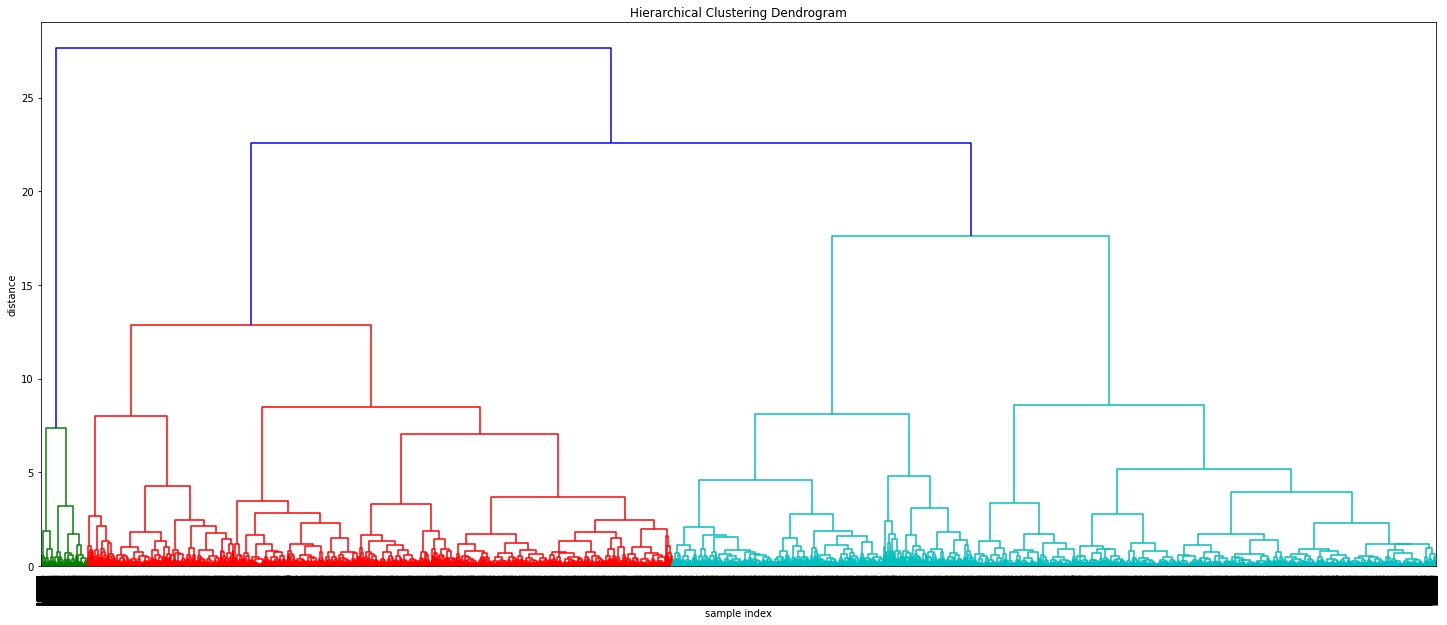

In [6]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

dendrogram(
    linkage_model,
    leaf_rotation=90., # rotates the x axis labels
    leaf_font_size=8., # font size for the x axis labels
)

plt.show()

In [9]:
print('TEST')

TEST


In [10]:
print('TEST')

TEST


Plot the truncated dendrogram.

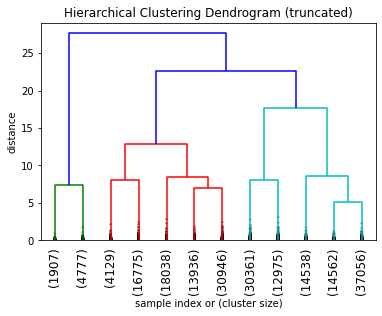

In [7]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')

dendrogram(
    linkage_model,
    truncate_mode='lastp', # show only the last p merged clusters
    p=12, # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, # to get a distribution impression in truncated branches
)

plt.show()

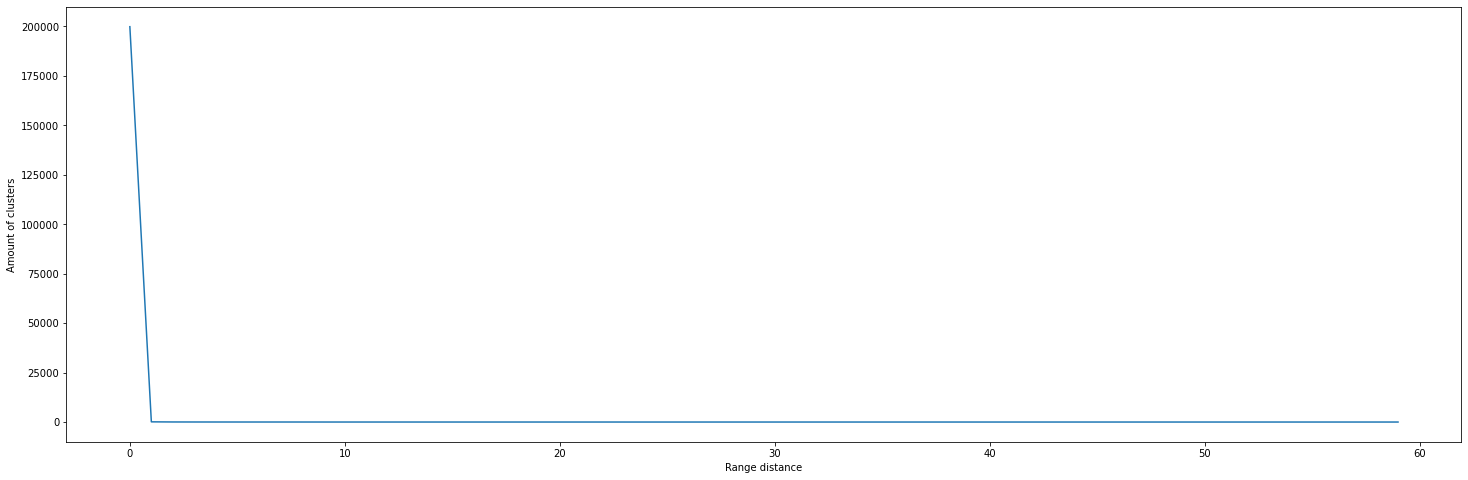

In [12]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

cluster_sizes = []

plt.figure(figsize=(25,8))

for x in range(0,60):
    max_d = x
    clusters = fcluster(linkage_model, max_d, criterion='distance')
    cluster_sizes.append(len(set(clusters)))

plt.plot(cluster_sizes)
plt.xlabel("Range distance")
plt.ylabel("Amount of clusters")
plt.show()

___